In [53]:
import os
import sys
import json
import glob
import random
import collections
import time
import re
import math
import numpy as np
import pandas as pd
import cv2
import random
import tensorflow as tf
import SimpleITK as sitk
import matplotlib.pyplot as plt
import seaborn as sns
import pydicom as dicom
import tensorflow as tf
import splitfolders

from itertools import cycle
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from PIL import Image
from sklearn.model_selection import train_test_split
from scipy import ndimage
from skimage import exposure
from pydicom.pixel_data_handlers.util import apply_voi_lut
from skimage import filters
from skimage import morphology
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from sklearn.cluster import KMeans

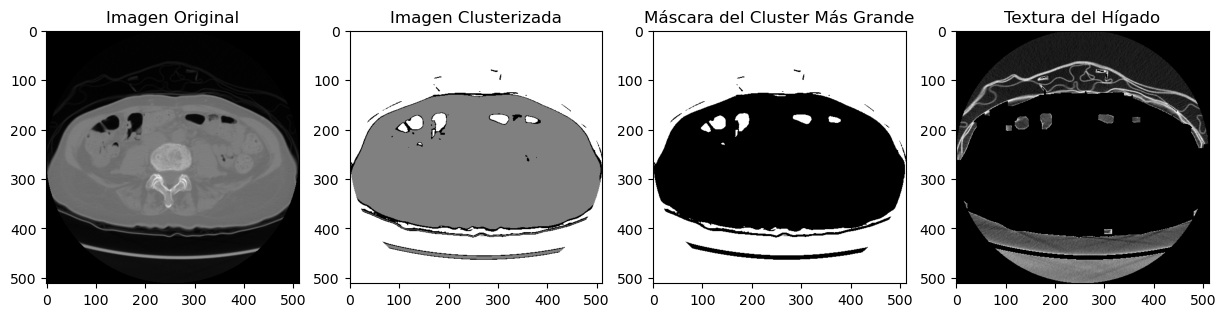

In [50]:
dicom_file_path = "C:/Users/javir/Documents/TFM/Imagenes_TFM/tcga_lihc/TCGA-BC-A3KF/1.3.6.1.4.1.14519.5.2.1.8421.4008.212149247533463904570758018240/CT_1.3.6.1.4.1.14519.5.2.1.8421.4008.335937776098701524768617381875/759e003d-9e95-4eef-95f4-feceb8d3f9d6.dcm"

# Leer el archivo DICOM
ds = dicom.dcmread(dicom_file_path)
image = ds.pixel_array

# Convertir la imagen a formato uint8
image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

# Aplanar la imagen para K-Means
flat_image = image.reshape((-1, 1))

# Aplicar K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(flat_image)
clustered_image = kmeans.labels_.reshape(image.shape)

# Encontrar el área de cada cluster
clusters, counts = np.unique(clustered_image, return_counts=True)
cluster_areas = dict(zip(clusters, counts))

# Identificar el cluster con el área más grande
largest_cluster = max(cluster_areas, key=cluster_areas.get)

# Crear una máscara para el cluster más grande (presumiblemente el hígado)
liver_mask = np.where(clustered_image == largest_cluster, 255, 0).astype(np.uint8)

# Aplicar la máscara a la imagen original
liver_texture = cv2.bitwise_and(image, image, mask=liver_mask)

# Opcional: Realizar una limpieza de la máscara para eliminar pequeñas áreas no deseadas
liver_mask_cleaned = ndimage.binary_opening(liver_mask, structure=np.ones((10, 10))).astype(np.uint8)

# Aplicar la máscara limpia a la imagen original
liver_texture_cleaned = cv2.bitwise_and(image, image, mask=liver_mask_cleaned)

# Mostrar las imágenes
plt.figure(figsize=(15, 5))

plt.subplot(1, 4, 1)
plt.imshow(image, cmap='gray')
plt.title('Imagen Original')

plt.subplot(1, 4, 2)
plt.imshow(clustered_image, cmap='gray')
plt.title('Imagen Clusterizada')

plt.subplot(1, 4, 3)
plt.imshow(liver_mask, cmap='gray')
plt.title('Máscara del Cluster Más Grande')

plt.subplot(1, 4, 4)
plt.imshow(liver_texture_cleaned, cmap='gray')
plt.title('Textura del Hígado')

plt.show()

In [2]:
def preprocesamiento(directorio_dicom, ruta_guardado):
# Leer el archivo DICOM y manejar posibles errores
    try:
        ds = dicom.dcmread(directorio_dicom)
        print(f'Archivo DICOM leído correctamente: {directorio_dicom}')
    except Exception as e:
        print(f'Error al leer el archivo DICOM: {e}')
        ds = None

    if ds is not None:
        # Verificar si el objeto DICOM tiene el atributo 'pixel_array'
        if hasattr(ds, 'pixel_array'):
            # Extraer la matriz de píxeles
            image = ds.pixel_array

            # Convertir la imagen a formato uint8
            image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

            # Modificar el contraste de la imagen
            # alpha: ganancia (contraste), beta: valor añadido (brillo)
            alpha = 1 # Contraste
            beta = -70 # Brillo

            image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)

            # Aplanar la imagen para K-Means
            flat_image = image.reshape((-1, 1))

            # Verificar que la imagen no esté vacía
            if flat_image is not None and len(flat_image) > 0:
                # Aplicar K-Means clustering
                try:
                    kmeans = KMeans(n_clusters=3, random_state=0).fit(flat_image)
                    clustered_image = kmeans.labels_.reshape(image.shape)

                    # Asumir que el cluster con el mayor número de píxeles corresponde al fondo y no es el hígado
                    unique, counts = np.unique(clustered_image, return_counts=True)
                    sorted_clusters = sorted(zip(unique, counts), key=lambda x: x[1])
                    liver_cluster = sorted_clusters[-1][0]  # Elegimos el segundo cluster más grande como hígado

                    # Crear una máscara para el hígado
                    liver_mask = np.where(clustered_image == liver_cluster, 255, 0).astype(np.uint8)

                    # Aplicar la máscara a la imagen original
                    liver_texture = cv2.bitwise_and(image, image, mask=liver_mask)

                    liver_mask_cleaned = ndimage.binary_opening(liver_mask, structure=np.ones((10, 10))).astype(np.uint8)
                    liver_texture_cleaned = cv2.bitwise_and(image, image, mask=liver_mask_cleaned)

                    # Guardado de la imagen
                    cv2.imwrite(ruta_guardado, liver_texture_cleaned)
            
                except Exception as e:
                    print(f'Error al aplicar K-Means: {e}')
            else:
                print('La imagen está vacía o no pudo ser aplanada correctamente.')
        else:
            print('El archivo DICOM no contiene una matriz de píxeles.')
    else:
        print('No se pudo leer el archivo DICOM.')

In [ ]:
ruta_principal = "C:/Users/javir/Documents/TFM/Imagenes_TFM/tcga_lihc"
ruta_imagenes_procesadas = "C:/Users/javir/Documents/TFM/Imagenes_TFM/imagenes_procesadas"

for paciente in os.listdir(ruta_principal):
    ruta_paciente = os.path.join(ruta_principal, paciente)
    for estudios in os.listdir(ruta_paciente):
        ruta_estudio = os.path.join(ruta_paciente, estudios)
        for archivo_dicom in os.listdir(ruta_estudio):
            ruta_dicom = os.path.join(ruta_estudio, archivo_dicom)
            num_imagen = 0
            for imagen in os.listdir(ruta_dicom):
                ruta_imagen = os.path.join(ruta_dicom, imagen)
                ruta_imagen = ruta_imagen.replace('\\', '/')
                num_imagen = num_imagen + 1
                nombre_imagenprocesada = paciente + "_" + estudios + "_" + str(num_imagen) + ".png"
                ruta_guardado = os.path.join(ruta_imagenes_procesadas, nombre_imagenprocesada)
                ruta_guardado = ruta_guardado.replace('\\', '/')
                preprocesamiento(ruta_imagen, ruta_guardado)

Archivo DICOM leído correctamente: C:/Users/javir/Documents/TFM/Imagenes_TFM/tcga_lihc/TCGA-BC-A10W/1.3.6.1.4.1.14519.5.2.1.8421.4008.196080699389036748278338540341/CT_1.3.6.1.4.1.14519.5.2.1.8421.4008.266800390798401875615081856127/0448bdc2-195c-46f7-a187-637a8fcb7a90.dcm
Archivo DICOM leído correctamente: C:/Users/javir/Documents/TFM/Imagenes_TFM/tcga_lihc/TCGA-BC-A10W/1.3.6.1.4.1.14519.5.2.1.8421.4008.196080699389036748278338540341/CT_1.3.6.1.4.1.14519.5.2.1.8421.4008.266800390798401875615081856127/0d23fe17-626e-4163-abd4-a9445619582b.dcm
Archivo DICOM leído correctamente: C:/Users/javir/Documents/TFM/Imagenes_TFM/tcga_lihc/TCGA-BC-A10W/1.3.6.1.4.1.14519.5.2.1.8421.4008.196080699389036748278338540341/CT_1.3.6.1.4.1.14519.5.2.1.8421.4008.266800390798401875615081856127/17aa5040-3873-4de1-ab1d-f46f20f9fff3.dcm
Archivo DICOM leído correctamente: C:/Users/javir/Documents/TFM/Imagenes_TFM/tcga_lihc/TCGA-BC-A10W/1.3.6.1.4.1.14519.5.2.1.8421.4008.196080699389036748278338540341/CT_1.3.6.1.4.

In [4]:
pd.set_option("display.max_columns", 500)

In [5]:
datos_clinicos = pd.read_csv("C:/Users/javir/Documents/TFM/clinical.project-tcga-lihc.2024-09-16/clinical.tsv", sep = "\t")

In [6]:
datos_clinicos[datos_clinicos["case_submitter_id"]== "TCGA-BC-A69H"]["ajcc_pathologic_stage"].iloc[0]
#ajcc_pathologic_stage
#ajcc_pathologic_t
#classification_of_tumor
#icd_10_code
#primary_diagnosis
#prior_malignancy
#tumor_depth
#year_of_diagnosis

'Stage II'

In [7]:
datos_clinicos["ajcc_pathologic_stage"].value_counts(normalize=True)
#Nos vamos a enfocar en los tres primeros estadíos en base a los datos que tenemos ya que en los demáss no hay información para el estudio y podría provocar falsos positivos por lo que se procede a acotar la clasificación de cancer

ajcc_pathologic_stage
Stage I       0.464191
Stage II      0.230769
Stage IIIA    0.172414
'--           0.063660
Stage IIIC    0.023873
Stage IIIB    0.023873
Stage III     0.007958
Stage IVB     0.005305
Stage IV      0.005305
Stage IVA     0.002653
Name: proportion, dtype: float64

In [8]:
datos_clinicos["ajcc_pathologic_stage"].value_counts()

ajcc_pathologic_stage
Stage I       350
Stage II      174
Stage IIIA    130
'--            48
Stage IIIC     18
Stage IIIB     18
Stage III       6
Stage IVB       4
Stage IV        4
Stage IVA       2
Name: count, dtype: int64

In [9]:
datos_clinicos["ajcc_pathologic_t"].value_counts()

ajcc_pathologic_t
T1     370
T2     186
T3      90
T3a     58
T4      26
T3b     14
'--      4
T2b      2
T2a      2
TX       2
Name: count, dtype: int64

In [10]:
datos_clinicos["classification_of_tumor"].unique()

array(['not reported'], dtype=object)

In [11]:
datos_clinicos["icd_10_code"].unique()

array(['C22.0'], dtype=object)

In [12]:
datos_clinicos["primary_diagnosis"].unique()

array(['Hepatocellular carcinoma, NOS',
       'Combined hepatocellular carcinoma and cholangiocarcinoma',
       'Hepatocellular carcinoma, fibrolamellar',
       'Hepatocellular carcinoma, clear cell type',
       'Clear cell adenocarcinoma, NOS',
       'Hepatocellular carcinoma, spindle cell variant'], dtype=object)

In [13]:
datos_clinicos[["prior_malignancy", "ajcc_pathologic_stage"]].groupby("ajcc_pathologic_stage").value_counts()
# No se ve una relación clara entre el estadío y la malignicidad 

ajcc_pathologic_stage  prior_malignancy
'--                    no                   38
                       yes                  10
Stage I                no                  314
                       yes                  36
Stage II               no                  158
                       yes                  16
Stage III              no                    6
Stage IIIA             no                  124
                       yes                   6
Stage IIIB             no                   12
                       yes                   6
Stage IIIC             no                   18
Stage IV               no                    4
Stage IVA              no                    2
Stage IVB              no                    4
Name: count, dtype: int64

In [14]:
datos_clinicos["tumor_depth"].unique()

array(["'--"], dtype=object)

In [15]:
datos_clinicos["year_of_diagnosis"].unique()
#Datos desde 1995 hasta 2013

array(['2007', '2005', '2009', '2013', '2006', '2011', '2012', '2010',
       '1999', '1998', '2008', '2000', "'--", '2002', '1996', '2001',
       '1995', '2004', '2003', '1997'], dtype=object)

In [16]:
datos_clinicos[datos_clinicos["ajcc_pathologic_stage"]== "Stage I"]["case_submitter_id"]

0      TCGA-DD-AAVP
1      TCGA-DD-AAVP
2      TCGA-DD-A4NP
3      TCGA-DD-A4NP
8      TCGA-G3-A7M8
           ...     
749    TCGA-GJ-A3OU
750    TCGA-DD-AAEH
751    TCGA-DD-AAEH
752    TCGA-KR-A7K2
753    TCGA-KR-A7K2
Name: case_submitter_id, Length: 350, dtype: object

In [17]:
datos_clinicos = datos_clinicos[datos_clinicos["ajcc_pathologic_stage"].isin(["Stage I", "Stage II", "Stage IIIA"])]
datos_clinicos.reset_index(drop=True, inplace=True)

In [18]:
labels = []
casos_descartados = []
casos_datos_clinicos = list(datos_clinicos["case_submitter_id"].unique())
for imagen in os.listdir("C:/Users/javir/Documents/TFM/Imagenes_TFM/imagenes_procesadas"):
    caso = imagen[:12]
    if caso in casos_datos_clinicos:
        estado = datos_clinicos[datos_clinicos["case_submitter_id"]== caso]["ajcc_pathologic_stage"].iloc[0]
        if estado == "Stage I":
            labels.append(0)
        elif estado == "Stage II":
            labels.append(1)
        else:
            labels.append(2)         
    else:
        casos_descartados.append(caso)

In [19]:
len(labels)
#Después de hacer la limpieza, nos han quedado 8432 imagenes. Anteriormente, teníamos casi 11k imágenes. Al descartar el 2% de datos que equivalía a los demás estadíos superiores tiene sentido que nos quede dicha cifra de datos de imagen a analizar.

8432

In [20]:
for imagen in os.listdir("C:/Users/javir/Documents/TFM/Imagenes_TFM/imagenes_procesadas"):
    ruta_imagen = os.path.join("C:/Users/javir/Documents/TFM/Imagenes_TFM/imagenes_procesadas", imagen)
    ruta_imagen = ruta_imagen.replace('\\', '/')
    borrar = 0
    with Image.open(ruta_imagen) as img:
        if imagen[:12] in casos_descartados:
            borrar = 1
    if borrar == 1:
        os.remove(ruta_imagen)

In [23]:
# Directorio de las imágenes y lista de labels
image_folder = 'C:/Users/javir/Documents/TFM/Imagenes_TFM/imagenes_procesadas'

# Obtener las rutas de las imágenes
image_paths = [os.path.join(image_folder, img) for img in sorted(os.listdir(image_folder))]

# Dividir en conjunto de entrenamiento y conjunto temporal (test + validación)
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    image_paths, labels, test_size=0.4, random_state=42
)

# Dividir el conjunto temporal en conjunto de prueba y validación
test_paths, val_paths, test_labels, val_labels = train_test_split(
    temp_paths, temp_labels, test_size=0.5, random_state=42
)

# Resultados
print("Entrenamiento:", len(train_paths), "imágenes")
print("Prueba:", len(test_paths), "imágenes")
print("Validación:", len(val_paths), "imágenes")

Entrenamiento: 5059 imágenes
Prueba: 1686 imágenes
Validación: 1687 imágenes


In [24]:
def load_images(image_paths, target_size=(128, 128)):
    images = []
    for path in image_paths:
        img = tf.keras.preprocessing.image.load_img(path, target_size=target_size)
        img = tf.keras.preprocessing.image.img_to_array(img)
        images.append(img)
    return np.array(images)

train_images = load_images(train_paths)
test_images = load_images(test_paths)
val_images = load_images(val_paths)

# Normalizar las imágenes
train_images = train_images / 255.0
test_images = test_images / 255.0
val_images = val_images / 255.0

# Convertir las etiquetas a formato categórico
num_classes = len(set(labels))
train_labels_cat = to_categorical(train_labels, num_classes=3)
test_labels_cat = to_categorical(test_labels, num_classes=3)
val_labels_cat = to_categorical(val_labels, num_classes=3)

In [25]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [26]:
history = model.fit(
    train_images, train_labels_cat,
    epochs=20,
    batch_size=32,
    validation_data=(val_images, val_labels_cat)
)

Epoch 1/20
159/159 [==============================] - 91s 553ms/step - loss: 0.7579 - accuracy: 0.6693 - val_loss: 0.4921 - val_accuracy: 0.7967
Epoch 2/20
159/159 [==============================] - 88s 552ms/step - loss: 0.3390 - accuracy: 0.8747 - val_loss: 0.2456 - val_accuracy: 0.9057
Epoch 3/20
159/159 [==============================] - 88s 553ms/step - loss: 0.1626 - accuracy: 0.9407 - val_loss: 0.1515 - val_accuracy: 0.9490
Epoch 4/20
159/159 [==============================] - 88s 552ms/step - loss: 0.1009 - accuracy: 0.9660 - val_loss: 0.1300 - val_accuracy: 0.9579
Epoch 5/20
159/159 [==============================] - 88s 554ms/step - loss: 0.0593 - accuracy: 0.9812 - val_loss: 0.1129 - val_accuracy: 0.9638
Epoch 6/20
159/159 [==============================] - 88s 554ms/step - loss: 0.0626 - accuracy: 0.9796 - val_loss: 0.0962 - val_accuracy: 0.9710
Epoch 7/20
159/159 [==============================] - 88s 554ms/step - loss: 0.0362 - accuracy: 0.9899 - val_loss: 0.0966 - val_ac

In [27]:
test_loss, test_acc = model.evaluate(test_images, test_labels_cat)
print(f'Test accuracy: {test_acc}')

53/53 [==============================] - 7s 130ms/step - loss: 0.0791 - accuracy: 0.9786
Test accuracy: 0.9786477088928223


In [28]:
def calculate_tpr_fpr(y_real, y_pred):
    # Calculates the confusion matrix and recover each element
    cm = confusion_matrix(y_real, y_pred)
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    TP = cm[1, 1]
    
    # Calculates tpr and fpr
    tpr =  TP/(TP + FN) # sensitivity - true positive rate
    fpr = 1 - TN/(TN+FP) # 1-specificity - false positive rate
    
    return tpr, fpr

In [29]:
def get_all_roc_coordinates(y_real, y_proba):
    tpr_list = [0]
    fpr_list = [0]
    for i in range(len(y_proba)):
        threshold = y_proba[i]
        y_pred = y_proba >= threshold
        tpr, fpr = calculate_tpr_fpr(y_real, y_pred)
        tpr_list.append(tpr)
        fpr_list.append(fpr)
    return tpr_list, fpr_list

In [33]:
def load_images(image_paths, target_size=(128, 128)):
    images = []
    for path in image_paths:
        img = tf.keras.preprocessing.image.load_img(path, target_size=target_size)
        img = tf.keras.preprocessing.image.img_to_array(img)
        images.append(img)
    return np.array(images)

In [30]:
def plot_roc_curve(tpr, fpr, scatter = True, ax = None):
    if ax == None:
        plt.figure(figsize = (5, 5))
        ax = plt.axes()
    
    if scatter:
        sb.scatterplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = [0, 1], y = [0, 1], color = 'green', ax = ax)
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

In [34]:
test_images = load_images(test_paths)

In [35]:
val_rn = model.predict(test_images)

53/53 [==============================] - 12s 206ms/step


In [51]:
y_pred = np.argmax(val_rn, axis=1)

In [54]:
cm = confusion_matrix(test_labels, y_pred)

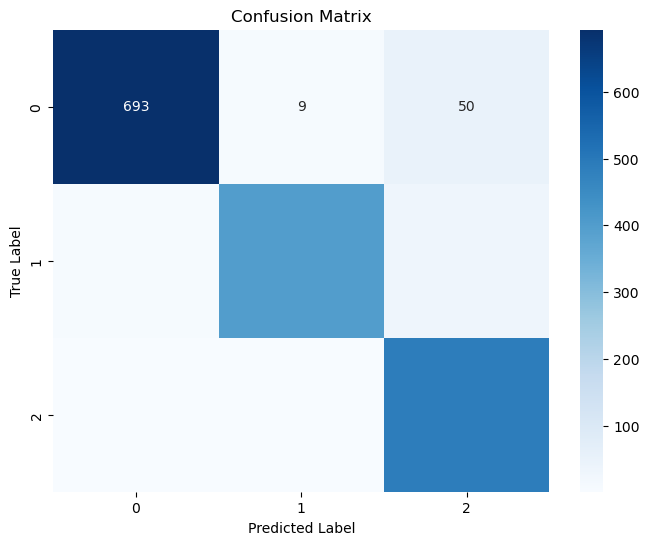

In [55]:
class_names = [0, 1, 2]

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [44]:
y_test_bin = label_binarize(test_labels, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

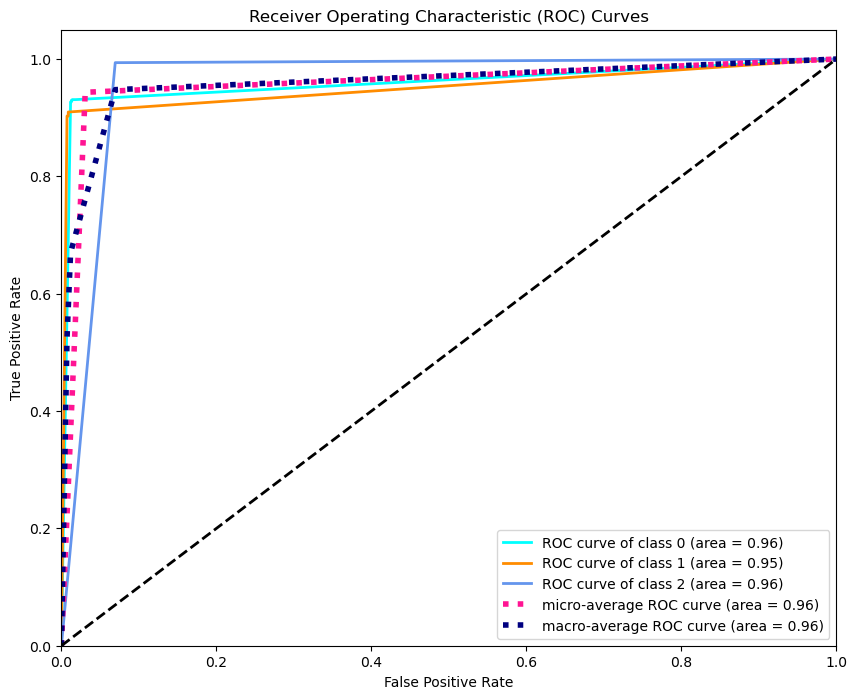

In [48]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], val_rn[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Calcular la curva ROC micro y macro promediada
# Micro
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), val_rn.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Macro
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Graficar todas las curvas ROC
plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=4,
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))

plt.plot(fpr["macro"], tpr["macro"], color='navy', linestyle=':', linewidth=4,
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()